In [1]:
import pandas as pd
import os
import numpy as np
import jieba
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import warnings
import bz2
warnings.filterwarnings('ignore')


## 首先导入数据集,微博评论语料库\
os.chdir(r'C:\\Users\\moonchild\\OneDrive\\MathandModel\\NLP\\WeiboCrapperAndEmotionAnalysis')
data = pd.read_csv(r'weibo_senti_100k.csv',encoding='utf-8')
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119988 entries, 0 to 119987
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   119988 non-null  int64 
 1   review  119988 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


### 分别获取评论原始文本以及文本极性

In [2]:
review = data.review.tolist()              # 获取评论数据
label = data.label.tolist()                # 文本极性,用1和0表示

In [48]:
review
# label

['\ufeff更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你]',
 '@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心，酒店都全部OK啦。',
 '姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢//@李欣芸SharonLee:大佬范儿[书呆子]',
 '美~~~~~[爱你]',
 '梦想有多大，舞台就有多大![鼓掌]',
 '[花心][鼓掌]//@小懒猫Melody2011: [春暖花开]',
 '某问答社区上收到一大学生发给我的私信：“偶喜欢阿姨！偶是阿姨控！”我回他：“阿姨稀饭小盆友！偶是小盆友控！” [哈哈]',
 '吃货们无不啧啧称奇，好不喜欢！PS:写错一个字！[哈哈]@森林小天使-波琪 @SEVEN厦门摄影师 @日月星辰-心在路上 @每种型号生两胎 @志远天下行 @监控防盗安装XM @创意美食simon哥 @漫游者-强子 @陈小kitty猫@游子的歌@solo在厦门',
 '#Sweet Morning#From now on,love yourself,enjoy living then smile.从现在开始，爱自己，享受生活并且微笑。[呵呵] [嘻嘻] [哈哈] [挤眼] [太开心] 早安、甜心们',
 '【霍思燕剖腹产下“小江江” 老公落泪】今晨9时霍思燕产下一名男婴，宝宝重8斤3两，母子平安。杜江的脸上洋溢着做爸爸的欣喜：宝宝小名叫“小江江”，眼睛像他，鼻子和嘴巴则像霍思燕，看到宝贝就忍不住落泪！恭喜@杜江侦察记 @霍思燕 ，祝福“小江江”在爱里健康地成长[爱你]...http://t.cn/z8EwSPU',
 '[鼓掌]//@慕春彦: 一流的经纪公司是超模的摇篮！[鼓掌] //@姚戈:东方宾利强大的名模军团！',
 '真好//@宁波华侨豪生大酒店：[可爱] [害羞]',
 '第一次见到有花瓣的面膜，一片抵普通面膜好几片 [哈哈]！补水神器啊，一帖见效！ 睡前一片，15分钟超神奇膜法，第二天起来你会发现你脸又白又嫩还有光泽，持续几天皮肤好像剥了壳的鸡蛋一样白白嫩嫩的[太开心]！ 明星推荐，美妆老师私藏的神奇"膜"法！8片礼盒装抢购地址>>>（去评论中找链接哦）',
 '好感动[亲亲]大家都陆陆续续收到超极本尼泊尔的奖品了，没想到

+ 将dataframe转换为列表,将正向数据和负面数据都放在一起

In [4]:
### 导入词向量模型,解压文件
os.chdir(r'C:\Users\moonchild\OneDrive\MathandModel\NLP\chinese_sentiment')
with open("embeddings/sgns.zhihu.bigram", 'wb') as new_file, open("embeddings/sgns.zhihu.bigram.bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))

In [5]:
### 将词向量模型转化为gensim的KeyedVectors格式
ChineseLangVectors = KeyedVectors.\
        load_word2vec_format('embeddings/sgns.zhihu.bigram', binary=False)

In [9]:
test_words = ['习近平','胡锦涛','林青霞','李白','莎士比亚']
ChineseLangVectors.doesnt_match(test_words)

'林青霞'

In [10]:
# 我们使用tensorflow的keras接口来建模
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, LSTM
from keras.layers import Bidirectional
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import re
import tensorflow as tf


In [58]:
train_tokens = []
for text in review:
    # 首先去除所有的标点符号
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    cut = jieba.cut(text)
    cutList = [i for i in cut]
    for i,word in enumerate(cutList):
        try:
            # cutList[i] = ChineseLangVectors[word].index
            cutList[i] = ChineseLangVectors.key_to_index[word]
        except:
            cutList[i] = 0
    train_tokens.append(cutList)


In [60]:
train_tokens[0]
len(train_tokens)

119988

train_tokens[0

**标准化索引长度**
> 选择最具代表性的索引长度,如果使用最长评论的长度来进行索引化,会造成大量计算资源的浪费

In [61]:
tokenLens = [len(tokens) for tokens in train_tokens]
tokenLens

[27,
 23,
 34,
 5,
 12,
 13,
 34,
 53,
 29,
 75,
 24,
 13,
 77,
 26,
 43,
 46,
 37,
 8,
 68,
 16,
 44,
 10,
 12,
 6,
 58,
 34,
 34,
 54,
 46,
 66,
 12,
 28,
 37,
 21,
 26,
 50,
 67,
 14,
 11,
 94,
 37,
 21,
 68,
 48,
 40,
 71,
 6,
 49,
 27,
 49,
 7,
 30,
 29,
 29,
 39,
 14,
 15,
 10,
 15,
 40,
 5,
 23,
 14,
 17,
 31,
 39,
 20,
 22,
 50,
 55,
 28,
 18,
 12,
 8,
 18,
 83,
 40,
 25,
 59,
 26,
 30,
 15,
 62,
 48,
 12,
 38,
 74,
 82,
 15,
 42,
 40,
 20,
 5,
 34,
 21,
 63,
 30,
 6,
 78,
 15,
 8,
 27,
 12,
 9,
 12,
 22,
 37,
 14,
 11,
 31,
 15,
 79,
 81,
 14,
 13,
 15,
 55,
 10,
 13,
 4,
 18,
 12,
 49,
 39,
 11,
 23,
 11,
 19,
 19,
 35,
 38,
 11,
 24,
 38,
 21,
 65,
 75,
 43,
 6,
 31,
 44,
 16,
 18,
 17,
 7,
 40,
 12,
 21,
 13,
 11,
 8,
 17,
 80,
 10,
 49,
 8,
 10,
 42,
 30,
 89,
 23,
 25,
 88,
 24,
 64,
 11,
 17,
 36,
 13,
 23,
 68,
 28,
 26,
 14,
 48,
 14,
 19,
 43,
 9,
 38,
 26,
 63,
 72,
 10,
 7,
 34,
 27,
 8,
 21,
 39,
 60,
 45,
 70,
 6,
 73,
 64,
 10,
 32,
 25,
 21,
 20,
 23,
 7,
 32,
 

In [62]:
np.mean(tokenLens)

33.86023602360236

In [63]:
maxTokens = int(np.mean(tokenLens) + 2 * np.std(tokenLens))
np.sum(np.array(tokenLens) < maxTokens) / len(tokenLens)


0.9578124479114578

In [84]:
maxTokens

78

> ps:很奇怪,看下面的图像似乎也不符合正态分布,平均值+2*标准差的方法却也能实现覆盖95%的数据
> 

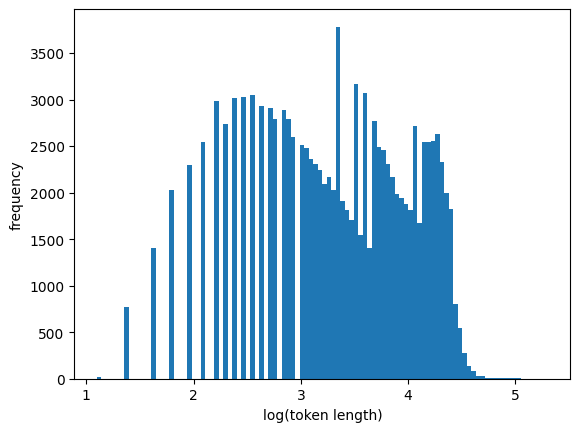

In [64]:
plt.hist(np.log(tokenLens),bins=100)
plt.xlabel('log(token length)')
plt.ylabel('frequency')
plt.show()

**反向Tokenize**,方便进行debug

In [67]:
def reverseTokenize(tokens):
    """
    this function is used to reverse the tokenization process
    """
    text = ''
    if tokens!=0:
        for i in tokens:
            if tokens!=0:
                text = text + ChineseLangVectors.index_to_key[i]                
            else:
                text = text + ' '
        return text

In [70]:
## 试试reverseTokenize函数能否正常使用
reverseTokenize(train_tokens[1000])

'我想到了，，主人，激光洗的时候还被击碎了，鱼眼睛[，转圈]，v谁不会自己来V:，:[哈哈]'

In [73]:
MAX_WORDS = 50_000
embeddingMatrix = np.zeros((MAX_WORDS,embeddingDim[0]))

for i in range(MAX_WORDS):
    embeddingMatrix[i,:] = ChineseLangVectors[ChineseLangVectors.index_to_key[i]]
    # 遍历,将词向量模型之中的数据赋值给指定的行
embeddingMatrix = embeddingMatrix.astype('float32')
embeddingMatrix.shape


(50000, 300)

In [75]:
## 检查index是否一一对应
np.sum(ChineseLangVectors[ChineseLangVectors.index_to_key[0]] == embeddingMatrix[0,:])

300

In [76]:
embeddingMatrix.shape

(50000, 300)

In [92]:
train_tokens[100]

[1261, 1862, 1046, 0, 3, 163, 146, 3]

**padding和truncating**
由于文本转换为tokens以后,每一串索引的长度并不相等,所以,为了方便模型的训练,我们在此将其长度进行标准化
对于长度不满标准长度的数据,在文本索引的前边填充0

In [90]:
"""
pad_sequence()函数将每个序列填充为相同的长度，长度为序列中最长的长度,缺省值为0,
如果指定了maxlen,则所有序列都会被截断为该长度,截断发生在序列的开始位置
padding='pre'表示在序列前面填充, padding='post'表示在序列后面填充
truncating='pre'表示截断序列的前面部分, truncating='post'表示截断序列的后面部分
"""
trainPad = pad_sequences(train_tokens,maxlen = maxTokens,padding = 'pre',truncating = 'pre')
trainPad.shape
trainPad[100]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 1261, 1862, 1046,    0,    3,  163,  146,
          3])

> 我们可以发现trainPad和train_tokens的区别.通过对数组前边填充0可以实现统一长度


In [91]:
trainPad[trainPad >= maxTokens] = 0
len(trainPad[100])

78

In [79]:
IndexArray = np.array(label)
type(IndexArray)

numpy.ndarray

**使用sklearn的函数来分割数据,创建练习数据以及测试数据,占比为0.9与0.1**


In [80]:
from sklearn.model_selection import train_test_split
reviewTrain, reivewTest, indexTrain,indexTest = train_test_split(trainPad,
                                                                 IndexArray,
                                                                 test_size=0.1,
                                                                 random_state=12)




**创建测试模型,向模型之中添加LTSM模型**



In [81]:
model = Sequential()

In [93]:
model.add(Embedding(MAX_WORDS,
                    embeddingDim[0],
                    weights=[embeddingMatrix],
                    input_length=maxTokens,
                    trainable=False))

In [94]:
layers1 = Bidirectional(LSTM(units=32, return_sequences=True))
model.add(layers1)
model.add(LSTM(units=16, return_sequences = False))

### 构建模型
使用BiLSTM
Embedding之后,一层使用BiLSTM返回sequences,然后第二层16的个单元的LSTM不返回sequence,只返回最终结果,最后是全连接层,使用sigmoid激活函数输出结果

In [105]:
model.add(Dense(1, activation='sigmoid'))        
optimizer = Adam(lr=1e-3)      # 使用Adam优化器,学习率为1e-3

In [106]:
model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])       # 报错是因为混用了tensorflow和keras的接口

In [107]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 78, 300)           15000000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 78, 64)           85248     
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 16)                5184      
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 15,090,613
Trainable params: 90,613
Non-trainable params: 15,000,000
_____________________________________

**最后的输出应该是(None,1),也就是仅仅输出情绪是正面还是负面的一个数据,而非是目前的(None,10)**

In [108]:
path_checkpoint = 'sentiment_checkpoint.keras'    # 建立储存权重的文件夹
checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                monitor='val_loss',
                                verbose=1,
                                save_weights_only=True,            
                                save_best_only=True)

In [109]:
# 加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
    

Error trying to load checkpoint.
Layer count mismatch when loading weights from file. Model expected 5 layers, found 4 saved layers.


In [110]:
# 定义early stopping,当验证集的loss不再下降时,停止训练
earlystopping = EarlyStopping(monitor='val_loss',
                                patience=3, verbose=1)
                                

In [111]:
# 自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                min_lr=1e-5,
                                patience=0,
                                verbose=1)
                                

In [112]:
# 定义回调函数
callbacks = [
    earlystopping,
    checkpoint,
    reduce_lr
]

### 开始训练

In [113]:
model.fit(reviewTrain,
            indexTrain,
            validation_split=0.1,
            epochs=20,
            batch_size=128,
            callbacks=callbacks)
            

Epoch 1/20
760/760 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9592
Epoch 1: val_loss improved from inf to 0.06939, saving model to sentiment_checkpoint.keras
760/760 [==============================] - 145s 176ms/step - loss: 0.1435 - accuracy: 0.9592 - val_loss: 0.0694 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 2/20
760/760 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9826
Epoch 2: val_loss improved from 0.06939 to 0.05094, saving model to sentiment_checkpoint.keras
760/760 [==============================] - 123s 161ms/step - loss: 0.0583 - accuracy: 0.9826 - val_loss: 0.0509 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 3/20
760/760 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9826
Epoch 3: val_loss improved from 0.05094 to 0.04520, saving model to sentiment_checkpoint.keras
760/760 [==============================] - 122s 161ms/step - loss: 0.0462 - accuracy: 0.9826 - val_loss: 0.0452 - val_accuracy: 0.9820 

In [114]:
result = model.evaluate(reivewTest, indexTest)
print("Accuracy: {0:.2%}".format(result[1]))

375/375 [==============================] - 16s 42ms/step - loss: 0.0415 - accuracy: 0.9823
Accuracy: 98.23%


## 模型训练结束
接下来输入文本爬取的文本进行测试
**此函数用于获取文本的极性**


In [153]:
import re
EmtionList = []
def getSentiment(comment):
    # print(comment)
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",comment)
    cut = jieba.cut(text)
    cut = [i for i in cut]
    for i,word in enumerate(cut):
        try:
            cut[i] = ChineseLangVectors.key_to_index[word]
            if cut[i] >= MAX_WORDS:
                cut[i] = 0
        except KeyError:
            cut[i] = 0
    tokens = pad_sequences([cut], maxlen=maxTokens,
                            padding='pre', truncating='pre')
    # 和此前预处理的步骤一样,这部分进行对文本的预处理
    result = model.predict(tokens)
    EmtionList.append(result)
    if result[0] >= 0.5:
        print('{0}是Positive,估值为{1}'.format(comment,result[0]))
    else:
        print('{0}情绪偏向Negative,估值为{1}'.format(comment,result[0]))   

**读取文件**

In [154]:
import os
os.chdir(r'C:\Users\moonchild\OneDrive\MathandModel\NLP\WeiboCrapperAndEmotionAnalysis')
resList = []
with open(r'res.txt','r',encoding='utf-8') as res:
    for i in res:
        resList.append(i)

In [155]:
for comment in resList:
    getSentiment(comment)

1/1 [==============================] - 0s 55ms/step
是真的对了，我是广州的，看到正在好转
是Positive,估值为[0.8044696]
1/1 [==============================] - 0s 55ms/step
不敢说在好转，但万一是，但愿这次大多数人别一转眼就忘了是靠牺牲了什么、做了什么而得来的。
是Positive,估值为[0.6778416]
1/1 [==============================] - 0s 52ms/step
总觉得还会反复。。
是Positive,估值为[0.7930413]
1/1 [==============================] - 0s 63ms/step
我也觉得呢，我对外部环境超敏感，我最近都觉得身体舒服了不少呢，我想大概是快好啦[嘻嘻]
是Positive,估值为[0.998354]
1/1 [==============================] - 0s 79ms/step
我们这里除非经营场所，普通市民四个月没做全民核酸了。。。这几天也有阳性案例，也没有要求全民做
是Positive,估值为[0.6863093]
1/1 [==============================] - 0s 81ms/step
这个感觉对了
是Positive,估值为[0.83402056]
1/1 [==============================] - 0s 61ms/step
郑州目前没感觉，满大街都是n95口罩，只要外出回家不查48h，其实就是一个大进步。现在外面核酸点排队排的吓死人
是Positive,估值为[0.67375565]
1/1 [==============================] - 0s 57ms/step
不了我取消关注且不会去你的餐饮吃饭
是Positive,估值为[0.811983]
1/1 [==============================] - 0s 52ms/step
恰恰相反 今年春节将是最难过的
是Positive,估值为[0.64595646]
1/1 [==============================] - 0s 58

In [160]:
EmtionList = [emtion[0][0] for emtion in EmtionList]
EmtionList

[0.8044696,
 0.6778416,
 0.7930413,
 0.998354,
 0.6863093,
 0.83402056,
 0.67375565,
 0.811983,
 0.64595646,
 0.6722459,
 0.19007707,
 0.93898416,
 0.7953058,
 0.8463276,
 0.0017967186,
 0.81697446,
 0.76449883,
 0.0018059091,
 0.85507464,
 0.9745722,
 0.85780054,
 0.8262821,
 0.87958807,
 0.7757655,
 0.8555125,
 0.7144803,
 0.8282248,
 0.7706813,
 0.8232393,
 0.99237263,
 0.80432045,
 0.8497554,
 0.8522809,
 0.8362023,
 0.627508,
 0.9848661,
 0.8415046,
 0.85809124,
 0.8393632,
 0.8450452,
 0.99837345,
 0.7692277,
 0.8573262,
 0.79316175,
 0.89105755,
 0.8626645,
 0.7938447,
 0.8564162,
 0.0017873214,
 0.82242346,
 0.86599386,
 0.80637556,
 0.7931736,
 0.8412828,
 0.80449194,
 0.8036859,
 0.8255749,
 0.8001317,
 0.82126594,
 0.6792141,
 0.72136617,
 0.84960777,
 0.87188524,
 0.8086433,
 0.7663199,
 0.69975317,
 0.7895261,
 0.99751806]

## 将获得的结果绘制为图表

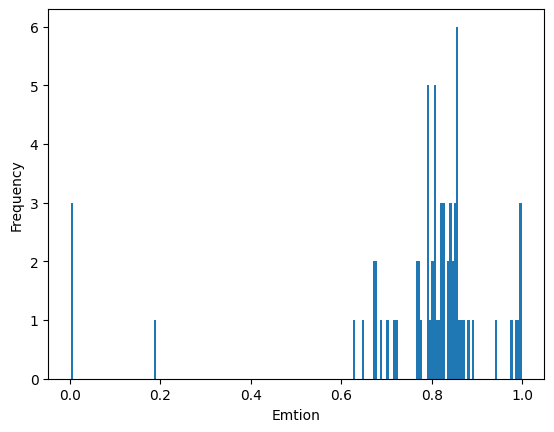

In [166]:
plt.hist(EmtionList,bins=200)
plt.xlabel('Emtion')
plt.ylabel('Frequency')

plt.show()

### 本次大作业全部内容结束
